# Fairness and Explainability with SageMaker Clarify

Ressources: https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_processing/fairness_and_explainability/fairness_and_explainability.html

### Runtime
This notebook takes approximately 30 minutes to run.

### Contents
- Overview
- Prerequisites and Data
- Initialize SageMaker
- Download data
- Loading the data: Adult Dataset
- Data inspection
- Data encoding and upload to S3
- Train and Deploy XGBoost Model
- Train Model
- Create Model
- Amazon SageMaker Clarify
- Detecting Bias
- Writing BiasConfig
- Pre-training Bias
- Post-training Bias
- Viewing the Bias Report
- Explaining Predictions
- Viewing the Explainability Report
- Clean Up

## Overview
Amazon SageMaker Clarify helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models. The product comes with the tools to help you with the following tasks.

- Measure biases that can occur during each stage of the ML lifecycle (data collection, model training and tuning, and monitoring of ML models deployed for inference).
- Generate model governance reports targeting risk and compliance teams and external regulators.
- Provide explanations of the data, models, and monitoring used to assess predictions.

This sample notebook walks you through:
- Key terms and concepts needed to understand SageMaker Clarify 
- Measuring the pre-training bias of a dataset and post-training bias of a model 
- Explaining the importance of the various input features on the model’s decision 
- Accessing the reports through SageMaker Studio if you have an instance set up.

In doing so, the notebook first trains a SageMaker XGBoost model using training dataset, then use SageMaker Clarify to analyze a testing dataset in CSV format. SageMaker Clarify also supports analyzing dataset in SageMaker JSON Lines dense format

## Prerequisites and Data
### Initialize SageMaker

In [1]:
!pip install -U seaborn

Keyring is skipped due to an exception: 'keyring.backends'


In [2]:
import os
import boto3
from sagemaker import Session
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-sagemaker-clarify"
region = session.boto_region_name

# Define IAM role
role = get_execution_role()
s3_client = boto3.client("s3")

## Download data
Data Source: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

- Let’s download the data and save it in the local folder with the name adult.data and adult.test from UCI repository.

### Dataset Info:
- Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.
- Dua Dheeru, and Efi Karra Taniskidou. “UCI Machine Learning Repository”. Irvine, CA: University of California, School of Information and Computer Science (2017).

In [3]:
adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]
if not os.path.isfile("./data/adult.data"):
    s3_client.download_file(
        "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.data", "./data/adult.data"
    )
    print("adult.data saved!")
else:
    print("adult.data already on disk.")

if not os.path.isfile("./data/adult.test"):
    s3_client.download_file(
        "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.test", "./data/adult.test"
    )
    print("adult.test saved!")
else:
    print("adult.test already on disk.")

adult.data already on disk.
adult.test already on disk.


## Loading the data: Adult Dataset
From the UCI repository of machine learning datasets, this database contains 14 features concerning demographic characteristics of 45,222 rows (32,561 for training and 12,661 for testing). The task is to predict whether a person has a yearly income that is more or less than $50,000.

Here are the features and their possible values: 
- Age: continuous. 
- Workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
- Fnlwgt: continuous (the number of people the census takers believe that observation represents). 
- Education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
- Education-num: continuous. 
- Marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
- Occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
- Relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
- Ethnic group: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
- Sex: Female, Male. * Note: this data is extracted from the 1994 Census and enforces a binary option on Sex 
- Capital-gain: continuous. 
- Capital-loss: continuous. 
- Hours-per-week: continuous. 
- Native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Next, we specify our binary prediction task:
- Target: <=50,000, >$50,000.

In [4]:
training_data = pd.read_csv(
    "./data/adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "./data/adult.test", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?", skiprows=1
).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. Let’s plot a few of the features that can be considered sensitive.
Let’s take a look specifically at the Sex feature of a census respondent. In the first plot we see that there are fewer Female respondents as a whole but especially in the positive outcomes, where they form ~1/7th of respondents.

In [5]:
training_data["Sex"].value_counts()

Male      20380
Female     9782
Name: Sex, dtype: int64

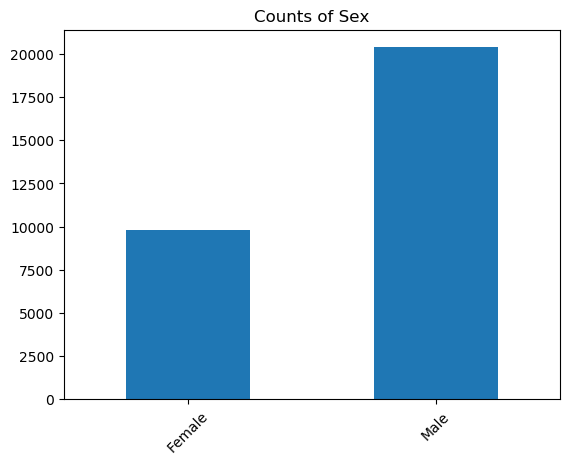

In [6]:
training_data["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=45)
plt.show()

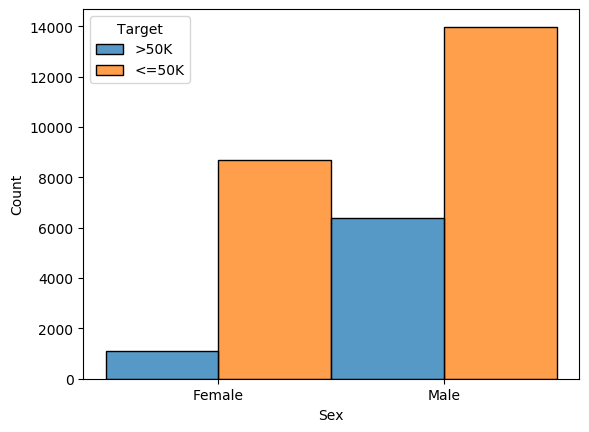

In [7]:
sns.histplot(data=training_data.sort_values(by='Sex'),
             x="Sex",
             hue="Target",
            multiple="dodge")
plt.show()

## Encode and Upload the Dataset
Here we encode the training and test data. Encoding input data is not necessary for SageMaker Clarify, but is necessary for the model.

In [8]:
from sklearn import preprocessing

def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


training_data = pd.concat([training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("./data/train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
test_target = testing_data["Target"]
test_features.to_csv("./data/test_features.csv", index=False, header=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [9]:
# inspect the whole dataframe
testing_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,25,2,226802,1,7,4,6,3,2,1,0,0,40,37,0
1,38,2,89814,11,9,2,4,0,4,1,0,0,50,37,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,37,1
3,44,2,160323,15,10,2,6,0,2,1,7688,0,40,37,1
5,34,2,198693,0,6,4,7,1,4,1,0,0,30,37,0


In [10]:
# inspect the feature dataframe
test_features.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,25,2,226802,1,7,4,6,3,2,1,0,0,40,37
1,38,2,89814,11,9,2,4,0,4,1,0,0,50,37
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,37
3,44,2,160323,15,10,2,6,0,2,1,7688,0,40,37
5,34,2,198693,0,6,4,7,1,4,1,0,0,30,37


In [11]:
# inspect the target array
test_target

0        0
1        0
2        1
3        1
5        0
        ..
16275    0
16276    0
16278    0
16279    0
16280    1
Name: Target, Length: 15060, dtype: int64

A quick note about our encoding: the “Female” Sex value has been encoded as 0 and “Male” as 1.

Lastly, let’s upload the data to S3.

In [12]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("./data/train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("./data/test_features.csv", "s3://{}/{}".format(bucket, prefix))

## Train XGBoost Model
### Train Model
Since our focus is on understanding how to use SageMaker Clarify, we keep it simple by using a standard XGBoost model.

In [13]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", 
                     region, 
                     version="1.2-1")

xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)


2022-12-01 15:48:31 Starting - Starting the training job...
2022-12-01 15:48:48 Starting - Preparing the instances for training..........
2022-12-01 15:49:44 Downloading - Downloading input data...
2022-12-01 15:50:05 Training - Downloading the training image..........
2022-12-01 15:51:01 Training - Training image download completed. Training in progress....
2022-12-01 15:51:21 Uploading - Uploading generated training model.
2022-12-01 15:51:32 Completed - Training job completed


### Create Model
Here we create the SageMaker model.

In [14]:
model_name = "DEMO-clarify-model-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

'DEMO-clarify-model-01-12-2022-15-58-43'

## Amazon SageMaker Clarify
Now that you have your model set up, let’s say hello to SageMaker Clarify!

In [19]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.m5.xlarge", 
    sagemaker_session=session
)

### Detecting Bias
SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics. #### Writing DataConfig and ModelConfig A DataConfig object communicates some basic information about data I/O to SageMaker Clarify. We specify where to find the input dataset, where to store the output, the target column (label), the header names, and the dataset type.

In [18]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [29]:
bias_report_output_path

's3://sagemaker-us-east-1-103721820087/sagemaker/DEMO-sagemaker-clarify/clarify-bias'

A ModelConfig object communicates information about your trained model. To avoid additional traffic to your production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing. * instance_type and instance_count specify your preferred instance type and instance count used to run your model on during SageMaker Clarify’s processing. The testing dataset is small so a single standard instance is good enough to run this example. If your have a large complex dataset, you may want to use a better instance type to speed up, or add more instances to enable Spark parallelization. * accept_type denotes the endpoint response payload format, and content_type denotes the payload format of request to the endpoint.

In [22]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

A ModelPredictedLabelConfig provides information on the format of your predictions. XGBoost model outputs probabilities of samples, so SageMaker Clarify invokes the endpoint then uses probability_threshold to convert the probability to binary labels for bias analysis. Prediction above the threshold is interpreted as label value 1 and below or equal as label value 0.

In [26]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

### Writing BiasConfig
SageMaker Clarify also needs information on what the sensitive columns (facets) are, what the sensitive features (facet_values_or_threshold) may be, and what the desirable outcomes are (label_values_or_threshold). SageMaker Clarify can handle both categorical and continuous data for facet_values_or_threshold and for label_values_or_threshold. In this case we are using categorical data.

We specify this information in the BiasConfig API. Here that the positive outcome is earning >$50,000, Sex is a sensitive category, and Female respondents are the sensitive group. group_name is used to form subgroups for the measurement of Conditional Demographic Disparity in Labels (CDDL) and Conditional Demographic Disparity in Predicted Labels (CDDPL) with regards to Simpson’s paradox.

In [23]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], # label of desired outcome 
    facet_name="Sex", # sensitive category
    facet_values_or_threshold=[0], # label of sensitive group i.e. females
    group_name="Age" # subgroups
)

### Pre-training Bias
Bias can be present in your data before any model training occurs. Inspecting your data for bias before training begins can help detect any data collection gaps, inform your feature engineering, and help you understand what societal biases the data may reflect.

Computing pre-training bias metrics does not require a trained model.

### Post-training Bias
Computing post-training bias metrics does require a trained model.

Unbiased training data (as determined by concepts of fairness measured by bias metric) may still result in biased model predictions after training. Whether this occurs depends on several factors including hyperparameter choices.

You can run these options separately with run_pre_training_bias() and run_post_training_bias() or at the same time with run_bias() as shown below.

In [27]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


Job Name:  Clarify-Bias-2022-12-01-16-15-18-061
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-103721820087/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-103721820087/sagemaker/DEMO-sagemaker-clarify/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-103721820087/sagemaker/DEMO-sagemaker-clarify/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...........

In [32]:
# import the bias analysis report 
contents = s3_client.list_objects(Bucket=bucket, Prefix=prefix)['Contents']
for f in contents:
    print(f['Key'])

sagemaker/DEMO-sagemaker-clarify/clarify-bias/analysis.json
sagemaker/DEMO-sagemaker-clarify/clarify-bias/analysis_config.json
sagemaker/DEMO-sagemaker-clarify/clarify-bias/report.html
sagemaker/DEMO-sagemaker-clarify/clarify-bias/report.ipynb
sagemaker/DEMO-sagemaker-clarify/clarify-bias/report.pdf
sagemaker/DEMO-sagemaker-clarify/test_features.csv
sagemaker/DEMO-sagemaker-clarify/train_data.csv


In [67]:
# import the report.pdf
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file("sagemaker/DEMO-sagemaker-clarify/clarify-bias/report.pdf", 
                                "bias-report.pdf")

you can inspect the bias analysis in a stylish way using the SageMaker resources tab on the left hand side; formerly you woud use the experiment tab

## Explaining Predictions
There are expanding business needs and legislative regulations that require explanations of why a model made the decision it did. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

Kernel SHAP algorithm requires a baseline (also known as background dataset). If not provided, a baseline is calculated automatically by SageMaker Clarify using K-means or K-prototypes in the input dataset. Baseline dataset type shall be the same as dataset_type of DataConfig, and baseline samples shall only include features. By definition, baseline should either be a S3 URI to the baseline dataset file, or an in-place list of samples. In this case we chose the latter, and put the first sample of the test dataset to the list.

In [74]:
shap_config = clarify.SHAPConfig(
    baseline=[test_features.iloc[0].values.tolist()],
    num_samples=30,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [75]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2022-12-01-18-37-00-400
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-103721820087/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-103721820087/sagemaker/DEMO-sagemaker-clarify/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-103721820087/sagemaker/DEMO-sagemaker-clarify/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMo

## Analysis of local explanations
It is possible to visualize the the local explanations for single examples in your dataset. You can use the obtained results from running Kernel SHAP algorithm for global explanations.

You can simply load the local explanations stored in your output path, and visualize the explanation (i.e., the impact that the single features have on the prediction of your model) for any single example.

In [76]:
local_explanations_out = pd.read_csv(explainability_output_path + "/explanations_shap/out.csv")
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
print("\nFeature values -- Label", training_data.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=90
)

/opt/conda/lib/python3.7/site-packages/botocore/utils.py:1723: FutureWarning: The S3RegionRedirector class has been deprecated for a new internal replacement. A future version of botocore may remove this class.
  category=FutureWarning,


PermissionError: Forbidden

## Clean Up
Finally, don’t forget to clean up the resources we set up and used for this demo!

In [ ]:
session.delete_model(model_name)